In [9]:
import classiq
classiq.authenticate(overwrite=True)

c:\Users\pariv\differential-equations\.venv\Lib\site-packages\classiq\_internals\authentication\token_manager.py:105: UserWarning: Overwriting an existing refresh token should only be done if it is compromised. Make sure this operation is necessary, and if not, remove the call to device registration.
  warnings.warn(


If a browser doesn't automatically open, please visit this URL from any trusted device to authenticate: https://auth.classiq.io/authorize?client_id=f6721qMOVoDAOVkzrv8YaWassRKSFX6Y&response_type=code&audience=https%3A%2F%2Fcadmium-be&redirect_uri=https%3A%2F%2Fauth.classiq.io%2Factivate%3Fuser_code%3DGVQF-WQZV&scope=offline_access
Your user code: GVQF-WQZV


### The mission:

Apply the algorithm from the paper to a simple, well-undesrtood physical system:
**the quantum harmonic oscilator**
Specically, implement a quantum algorithm to solve:

$$y''+\omega²y = 0, \quad y(0)= 1, \quad y'(0)=1, \quad \omega=1$$

Once implemented, **use the resulting quantum state** to evaluate the **system's kinetic and potential energies as a function of time** in the interval  $[0,1]$.

Explore **how varying algorithmic parameters**, such as the bounds used in `inplace_prepare_state()`, **affects the accuracy of these energy values**.

Finally, analyze how resource-efficient your implementation is by comparing circuit depth and width under different optimization settings.

### Problem cited from the paper
> The description of the problem for solving LDEs is as follows.
> A unknown vector $x(t)$ starts from a $x(0)$ and follows an evolution described by and LDE 
> $$\frac{dx(t)}{dt} = Mx(t) + b,$$
> where where $M$ is an arbitrary $N\times N$ matrix, while $b$ and $x(t)$ are $N$-dimenional vectors

We known that the analytical solution of the equation can be written as $$x(t) = e^{Mt} x(0) + (e^{Mt} - I)M^{-1}b $$


### Algorithm presented in the paper

Unlike the classic computing which solve the equation is aproximately $O(N³)$ this algorithm already requires $O(log N)$ time. In other words this quantum algorithm is faster than the other algorithm in classic computing.

Finding $x(t)$ based on our quantum algorithm. By Taylor expansion, the solution x(t) is approximately

$$x(t) \approx \sum$$

### Harmonic Oscilator Equation
We have $$y'' + \omega^2y = 0$$ we knonw that $\omega = 1$
$$y'' + y = 0$$
But the algorithm presented by paper is only enable for linear differential equations with the form: $$\frac{dx(t)}{dt} = Mx(t) + b$$

Can we define a vector state $$x(t) = \begin{pmatrix} x_1(t) \\ x_2(t) \end{pmatrix}$$
where:
$$\begin{matrix} x_1(t) & = & y(t) & \text{which represents the position} \\ x_2(t) & = & y'(t) & \text{which represents the volicity} \end{matrix}$$

### Derivation of the matricial system
Now, let $x(t)$ be the vector that change with the time.

First component: $$\frac{dx_1(t)}{dt} = y'(t) $$ But we knew the definition above that $y'(t) = x_2(t)$. Therefore $$x'_1(t) = x_2(t)$$

Secondth component: $$\frac{dx_2(t)}{dt} = y''(t) $$ Usign our original differential equation $$y'' + y=0 \rightarrow y'' = -y$$ And we knew that $y = x_1$, we have $$x'_2(t) = -x_1(t)$$

Now both equations in the matricial equation:
$$\begin{pmatrix} x'_1(t) \\ x'_2(t) \end{pmatrix} = \begin{pmatrix} 0 & 1 \\ -1 & 0 \end{pmatrix} \begin{pmatrix} x_1(t) \\ x_2(t) \end{pmatrix} $$

### Replacement in the Xin et al. Algorithm 
we have $$\frac{dx(t)}{dt} = Mx(t) + b$$
where
$$
\begin{matrix}
M & = & \begin{pmatrix} 0 & 1 \\ -1 & 0 \end{pmatrix} \\[.5cm]
b & = & \begin{pmatrix} 0 \\ 0 \end{pmatrix} \\[.5cm]
x(0) & = & \begin{pmatrix} 1 \\ 1 \end{pmatrix} \\
\end{matrix}
$$

From the paper the algorithm is:
$$
x(t) \approx \sum^k_{m=0} \frac{(Mt)^m}{m!} x(0) + \sum^k_{n=1}\frac{M^{n-1}t^n}{n!}b
$$
we choose $k = 4$

We have $$x(t)\approx \sum^4_{m=0} \frac{(Mt)^m}{m!}x(0) $$
The algorithm requires computed the power of $M^m$. We note that matrix $M$ is proportional to quantum gate of Pauly-Y ($\sigma_y$):
$$
    \sigma_y = \begin{pmatrix} 0 & -i \\ i & 0 \end{pmatrix} 
    \rightarrow M = i\sigma_y
$$

Now, we have

$$
\begin{matrix}
    M^0 & = & I \\
    M^1 & = & i\sigma_y \\
    M^2 & = & (i\sigma_y)^2 & =&  -I \\
    M³ & = & -i\sigma_y \\
    M^4 & = & I

\end{matrix}
$$

This meaning that the power of M are cyclics and $k=3$ is better chose than $k=4$

### Quantum States
The module of our initial vector is $||x(0)|| = \sqrt{1^2 +1²} = \sqrt 2$

The vector $x(0)$ can be described by quantum states 
$$
\ket{x(0)} = \frac{1}{\sqrt 2} 
\begin{pmatrix} 1 \\ 1 \end{pmatrix} = \frac{1}{\sqrt 2}\ket 0 + \frac{1}{\sqrt 2}\ket 1  
$$

In [10]:
import numpy as np
from classiq import *
def create_harmonic_oscillator_model(t: float, error_bound: float):
    """
    Genera el modelo cuántico LCU para el oscilador armónico en un instante t.
    """

    # 1. Calculamos las probabilidades teóricas para la serie de Taylor (k=3)
    # Pesos: w_0 = 1, w_1 = t, w_2 = t^2 / 2, w_3 = t^3 / 6
    weights = np.array([1.0, t, (t**2)/2.0, (t**3)/6.0])
    probabilities = (weights**2 / np.sum(weights**2)).tolist()
    # 2. Definimos la operación multicontrolada (El núcleo LCU)
    @qfunc
    def lcu_operations(ancilla: QArray[QBit], work: QBit):
        # M = iY.
        # Si m_0 = 1 (bit menos significativo), aplicamos iY.
        # RY(-pi) equivale exactamente a iY (salvo una fase global que no afecta aquí).
        control(ancilla[0], lambda: RY(-np.pi, work))

        # Si m_1 = 1 (bit más significativo), necesitamos aplicar -I.
        # Aplicar Z al cúbit de control agrega una fase de -1 a esa rama del estado.
        Z(ancilla[1])

    # ¡La magia de la superposición! Si m=3 (ambos bits son 1),
    # el circuito aplica automáticamente ambas operaciones (-1 * iY = -iY).
    # 3. Definimos la función principal del circuito
    @qfunc
    def main(work: Output[QArray[QBit]], ancilla: Output[QArray[QBit]]):
        # Asignamos los registros
        allocate(1, work)
        allocate(2, ancilla)

        # A. Codificación: Preparar el estado inicial x(0) = |+>
        H(work[0])

        # B. Codificación: Preparar pesos de Taylor en las ancillas
        inplace_prepare_state(probabilities=probabilities, bound=error_bound, target=ancilla)

        # C. Creación de Entrelazamiento: Aplicar operaciones controladas M^m
        lcu_operations(ancilla, work[0])

        # D. Decodificación: Invertir la preparación del estado (Uncompute)
        invert(lambda: inplace_prepare_state(probabilities=probabilities, bound=error_bound, target=ancilla))
        # 4. Sintetizar y retornar el modelo

    quantum_model = create_model(main)
    return quantum_model, probabilities

Ejecutando simulaciones cuánticas. Esto puede tardar un momento...
Vista previa de los datos:
          t   V_quant   K_quant   E_quant   V_exact   K_exact  E_exact
0  0.000000  0.500977  0.499023  1.000000  0.500000  0.500000      1.0
1  0.071429  0.607737  0.545828  1.153565  0.571186  0.428814      1.0
2  0.142857  0.696555  0.634156  1.330711  0.640921  0.359079      1.0
3  0.214286  0.844855  0.690198  1.535053  0.707786  0.292214      1.0
4  0.285714  1.055738  0.715013  1.770751  0.770417  0.229583      1.0


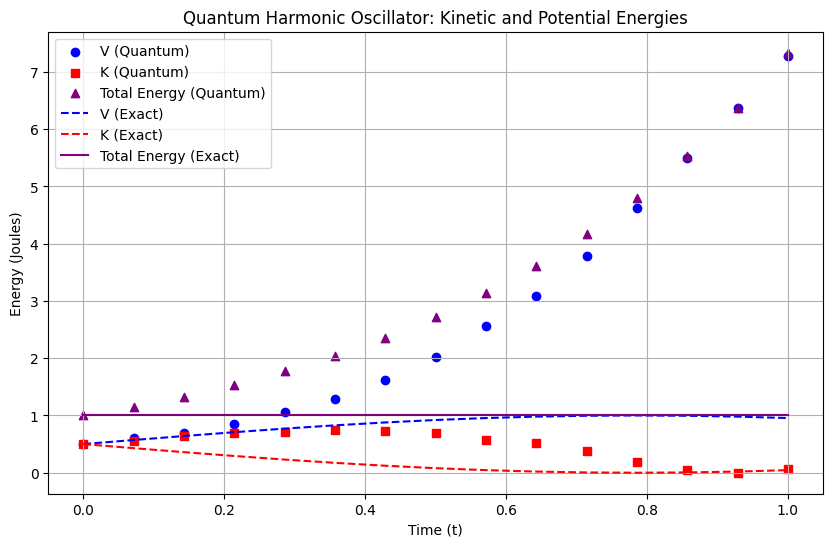

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from classiq import synthesize, execute


def create_harmonic_oscillator_model(t: float, error_bound: float):
    #Añadimos el termino (t**4)/24.0 para k=4

    weights = np.array([1.0, t, (t**2)/2.0, (t**3)/6.0, (t**4)/24.0])
    weights_padded = np.pad(weights,(0,3),"constant")
    probabilities = (weights_padded**2 / np.sum(weights_padded**2)).tolist()
    @qfunc
    def lcu_operations(ancilla: QArray[QBit], work: QBit):
        control(ancilla[0], lambda: RY(-np.pi, work))
        Z(ancilla[1])
    @qfunc
    def main(work: Output[QArray[QBit]], ancilla: Output[QArray[QBit]]):
        allocate(1, work)
        allocate(3, ancilla)

        H(work[0])
        inplace_prepare_state(probabilities=probabilities, bound=error_bound, target=ancilla)
        lcu_operations(ancilla, work[0])
        invert(lambda: inplace_prepare_state(probabilities=probabilities, bound=error_bound, target=ancilla))

    quantum_model = create_model(main)
    return quantum_model, probabilities

def run_simulation_and_calculate_energies(time_steps, error_bound=0.01):
    results_data = []
    for t in time_steps:
        quantum_model, probs = create_harmonic_oscillator_model(t, error_bound)

        qprog = synthesize(quantum_model)
        results = execute(qprog).result()
        counts = results[0].value.parsed_counts # type: ignore

        valid_counts_0 = 0
        valid_counts_1 = 0
        
        for state in counts:
            ancilla_val = state.state.get('ancilla', [])
            work_val = state.state.get('work', [])
            if ancilla_val == [0, 0, 0]: 
                if work_val == [0]:
                    valid_counts_0 += state.shots
                elif work_val == [1]:
                    valid_counts_1 += state.shots
                    
        total_valid = valid_counts_0 + valid_counts_1
        
        if total_valid == 0:
            continue

        P_0 = valid_counts_0 / total_valid
        P_1 = valid_counts_1 / total_valid
        N_squared = 1 + t + (t**2)/2 + (t**3)/6 + (t**4)/24.0
        V_quant = (N_squared**2) * P_0
        K_quant = (N_squared**2) * P_1
        E_quant = V_quant + K_quant

        y_exact = np.cos(t) + np.sin(t)
        y_prime_exact = np.cos(t) - np.sin(t)

        V_exact = 0.5 * (y_exact**2)
        K_exact = 0.5 * (y_prime_exact**2)
        E_exact = V_exact + K_exact

        results_data.append({
            't': t,
            'V_quant': V_quant, 'K_quant': K_quant, 'E_quant': E_quant,
            'V_exact': V_exact, 'K_exact': K_exact, 'E_exact': E_exact
        })

    return pd.DataFrame(results_data)


time_array = np.linspace(0, 1, 15)
bound_to_test = 0.01 
print("Ejecutando simulaciones cuánticas. Esto puede tardar un momento...")
df_results = run_simulation_and_calculate_energies(time_array, error_bound=bound_to_test)
print("Vista previa de los datos:")
print(df_results.head())
plt.figure(figsize=(10, 6))
plt.scatter(df_results['t'], df_results['V_quant'], label='V (Quantum)', color='blue', marker='o')
plt.scatter(df_results['t'], df_results['K_quant'], label='K (Quantum)', color='red', marker='s')
plt.scatter(df_results['t'], df_results['E_quant'], label='Total Energy (Quantum)', color='purple', marker='^')
plt.plot(df_results['t'], df_results['V_exact'], label='V (Exact)', color='blue', linestyle='--')
plt.plot(df_results['t'], df_results['K_exact'], label='K (Exact)', color='red', linestyle='--')
plt.plot(df_results['t'], df_results['E_exact'], label='Total Energy (Exact)', color='purple', linestyle='-')
plt.title('Quantum Harmonic Oscillator: Kinetic and Potential Energies')
plt.xlabel('Time (t)')
plt.ylabel('Energy (Joules)')
plt.legend()
plt.grid(True)
plt.show()

--- Iniciando Análisis de Estrés en t=4.5 ---
--- Iniciando Análisis de Optimización ---


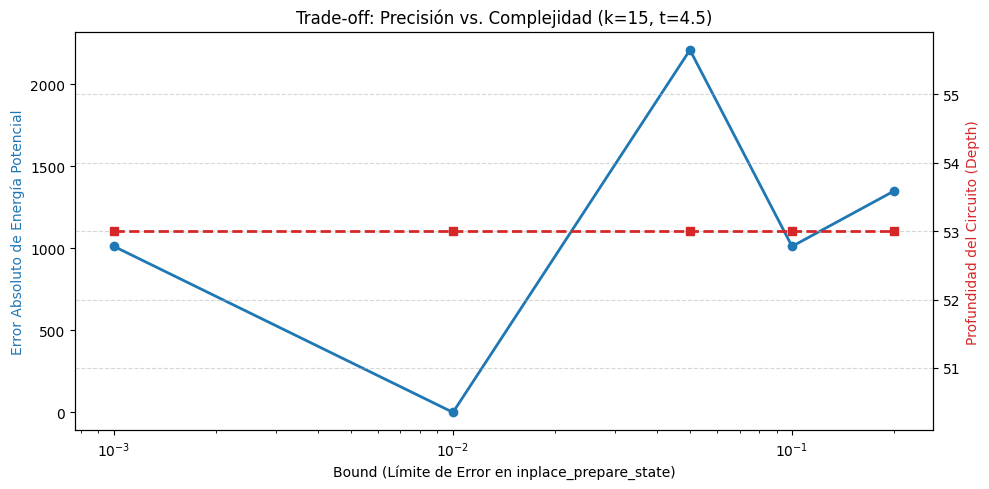

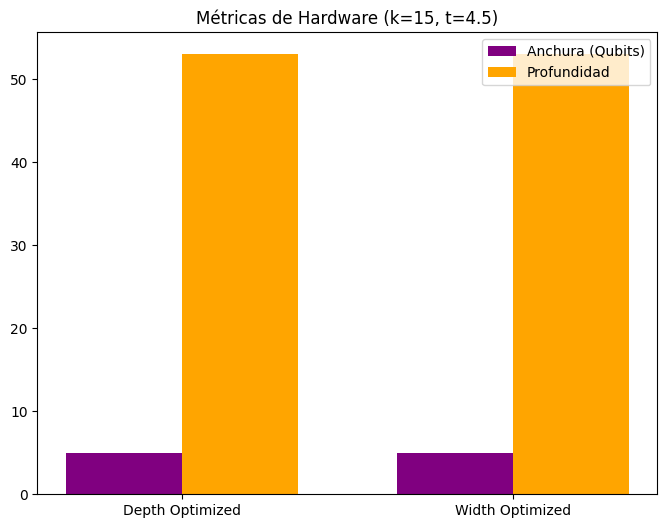

In [12]:
import numpy as np
import math
import matplotlib.pyplot as plt
from classiq import synthesize, execute, Preferences, OptimizationParameter
from classiq import QArray, QBit, Output, allocate, H, inplace_prepare_state, control, RY, Z, invert, create_model, qfunc

def create_stress_model(t: float, error_bound: float):
    weights = np.array([(t**m)/math.factorial(m) for m in range(16)])
    probabilities = (weights**2 / np.sum(weights**2)).tolist()

    @qfunc
    def lcu_operations_stress(ancilla: QArray[QBit], work: QBit):
        control(ancilla[0], lambda: RY(-np.pi, work))
        Z(ancilla[1])

    @qfunc
    def main(work: Output[QArray[QBit]], ancilla: Output[QArray[QBit]]):
        allocate(1, work)
        allocate(4, ancilla)
        H(work[0])
        inplace_prepare_state(probabilities=probabilities, bound=error_bound, target=ancilla)
        lcu_operations_stress(ancilla, work[0])
        invert(lambda: inplace_prepare_state(probabilities=probabilities, bound=error_bound, target=ancilla))

    return create_model(main)

def analyze_bound_effect_stress(t_fixed=4.5, bounds_to_test=[0.001, 0.01, 0.05, 0.1, 0.2]):
    print(f"--- Iniciando Análisis de Estrés en t={t_fixed} ---")
    errors = []
    depths = []
    
    y_exact = np.cos(t_fixed) + np.sin(t_fixed)
    V_exact = 0.5 * (y_exact**2) 
    
    for bound in bounds_to_test:
        quantum_model = create_stress_model(t_fixed, bound)
        qprog = synthesize(quantum_model)
        depths.append(qprog.transpiled_circuit.depth)
        
        results = execute(qprog).result()
        counts = results[0].value.parsed_counts  # type: ignore
        
        valid_0, valid_1 = 0, 0
        for state in counts:
            if state.state.get('ancilla', []) == [0, 0, 0, 0]: 
                if state.state.get('work', []) == [0]: valid_0 += state.shots
                elif state.state.get('work', []) == [1]: valid_1 += state.shots
                    
        total_valid = valid_0 + valid_1
        if total_valid == 0:
            errors.append(None)
            continue
            
        P_0 = valid_0 / total_valid
        
        N_squared = sum([(t_fixed**m)/math.factorial(m) for m in range(86)])
        V_quant = (N_squared**2) * P_0
        
        error = abs(V_quant - V_exact)
        errors.append(error)
        
    return bounds_to_test, errors, depths

def analyze_optimization_settings_stress(t_fixed=4.5, bound=0.01):
    print(f"--- Iniciando Análisis de Optimización ---")
    quantum_model = create_stress_model(t_fixed, bound)
    
    prefs_depth = Preferences(optimization_parameter=OptimizationParameter.DEPTH)
    qprog_depth = synthesize(quantum_model, preferences=prefs_depth)
    
    prefs_width = Preferences(optimization_parameter=OptimizationParameter.WIDTH)
    qprog_width = synthesize(quantum_model, preferences=prefs_width)
    
    return {
        'Depth Optimized': {'width': qprog_depth.data.width, 'depth': qprog_depth.transpiled_circuit.depth},
        'Width Optimized': {'width': qprog_width.data.width, 'depth': qprog_width.transpiled_circuit.depth}
    }

bounds, energy_errors, circuit_depths = analyze_bound_effect_stress()
opt_metrics = analyze_optimization_settings_stress()

fig, ax1 = plt.subplots(figsize=(10, 5))
color = 'tab:blue'
ax1.set_xlabel('Bound (Límite de Error en inplace_prepare_state)')
ax1.set_ylabel('Error Absoluto de Energía Potencial', color=color)
ax1.plot(bounds, energy_errors, color=color, marker='o', linewidth=2)
ax1.set_xscale('log')

ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Profundidad del Circuito (Depth)', color=color)  
ax2.plot(bounds, circuit_depths, color=color, marker='s', linestyle='--', linewidth=2)
plt.title('Trade-off: Precisión vs. Complejidad (k=15, t=4.5)')
fig.tight_layout()  
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

labels = ['Depth Optimized', 'Width Optimized']
widths = [opt_metrics['Depth Optimized']['width'], opt_metrics['Width Optimized']['width']]
depths = [opt_metrics['Depth Optimized']['depth'], opt_metrics['Width Optimized']['depth']]

x = np.arange(len(labels))
width_bar = 0.35  

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x - width_bar/2, widths, width_bar, label='Anchura (Qubits)', color='purple')
ax.bar(x + width_bar/2, depths, width_bar, label='Profundidad', color='orange')
ax.set_title('Métricas de Hardware (k=15, t=4.5)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()